<a href="https://colab.research.google.com/github/benmccloskey/food_industry/blob/main/Sentiment_Analysis_Food_Reviews_ChatGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.4 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, DistilBertTokenizer
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/reviews/Altomontes_reviews.csv')

fake_positive = pd.read_csv('/content/drive/MyDrive/reviews/generated_positive_reviews - Sheet1.csv')

fake_negative = pd.read_csv('/content/drive/MyDrive/reviews/generated_negative_reviews - Sheet1.csv')

In [ ]:
#Dataset Sentiment Values
fake_positive['sentiment'] = 1
fake_negative['sentiment'] = 0
data['sentiment'] = data['Rating'].apply(lambda x: 0 if x < 4 else 1)

data.drop(['Month', 'Year','Rating', 'Platform'],axis=1,inplace=True)

In [ ]:
reviews = pd.concat([data,fake_positive,fake_negative])

In [ ]:
reviews = reviews.reset_index(drop=True)
reviews.sentiment.value_counts()

1    1126
0    1124
Name: sentiment, dtype: int64

In [ ]:
df = reviews

In [ ]:
df.rename({'Review':'content'},axis=1,inplace=True)
df.head()

,content,sentiment
0,Someone in the prep kitchen LOVES salt! The mu...,0
1,Great looking store in Warminster but...just l...,0
2,Always friendly workers very helpful and fresh...,1
3,A local gem which also provides specialty Ital...,1
4,Countless times I have ordered sandwiches from...,0


Text(0.5, 1.0, 'Reviews Distribution')

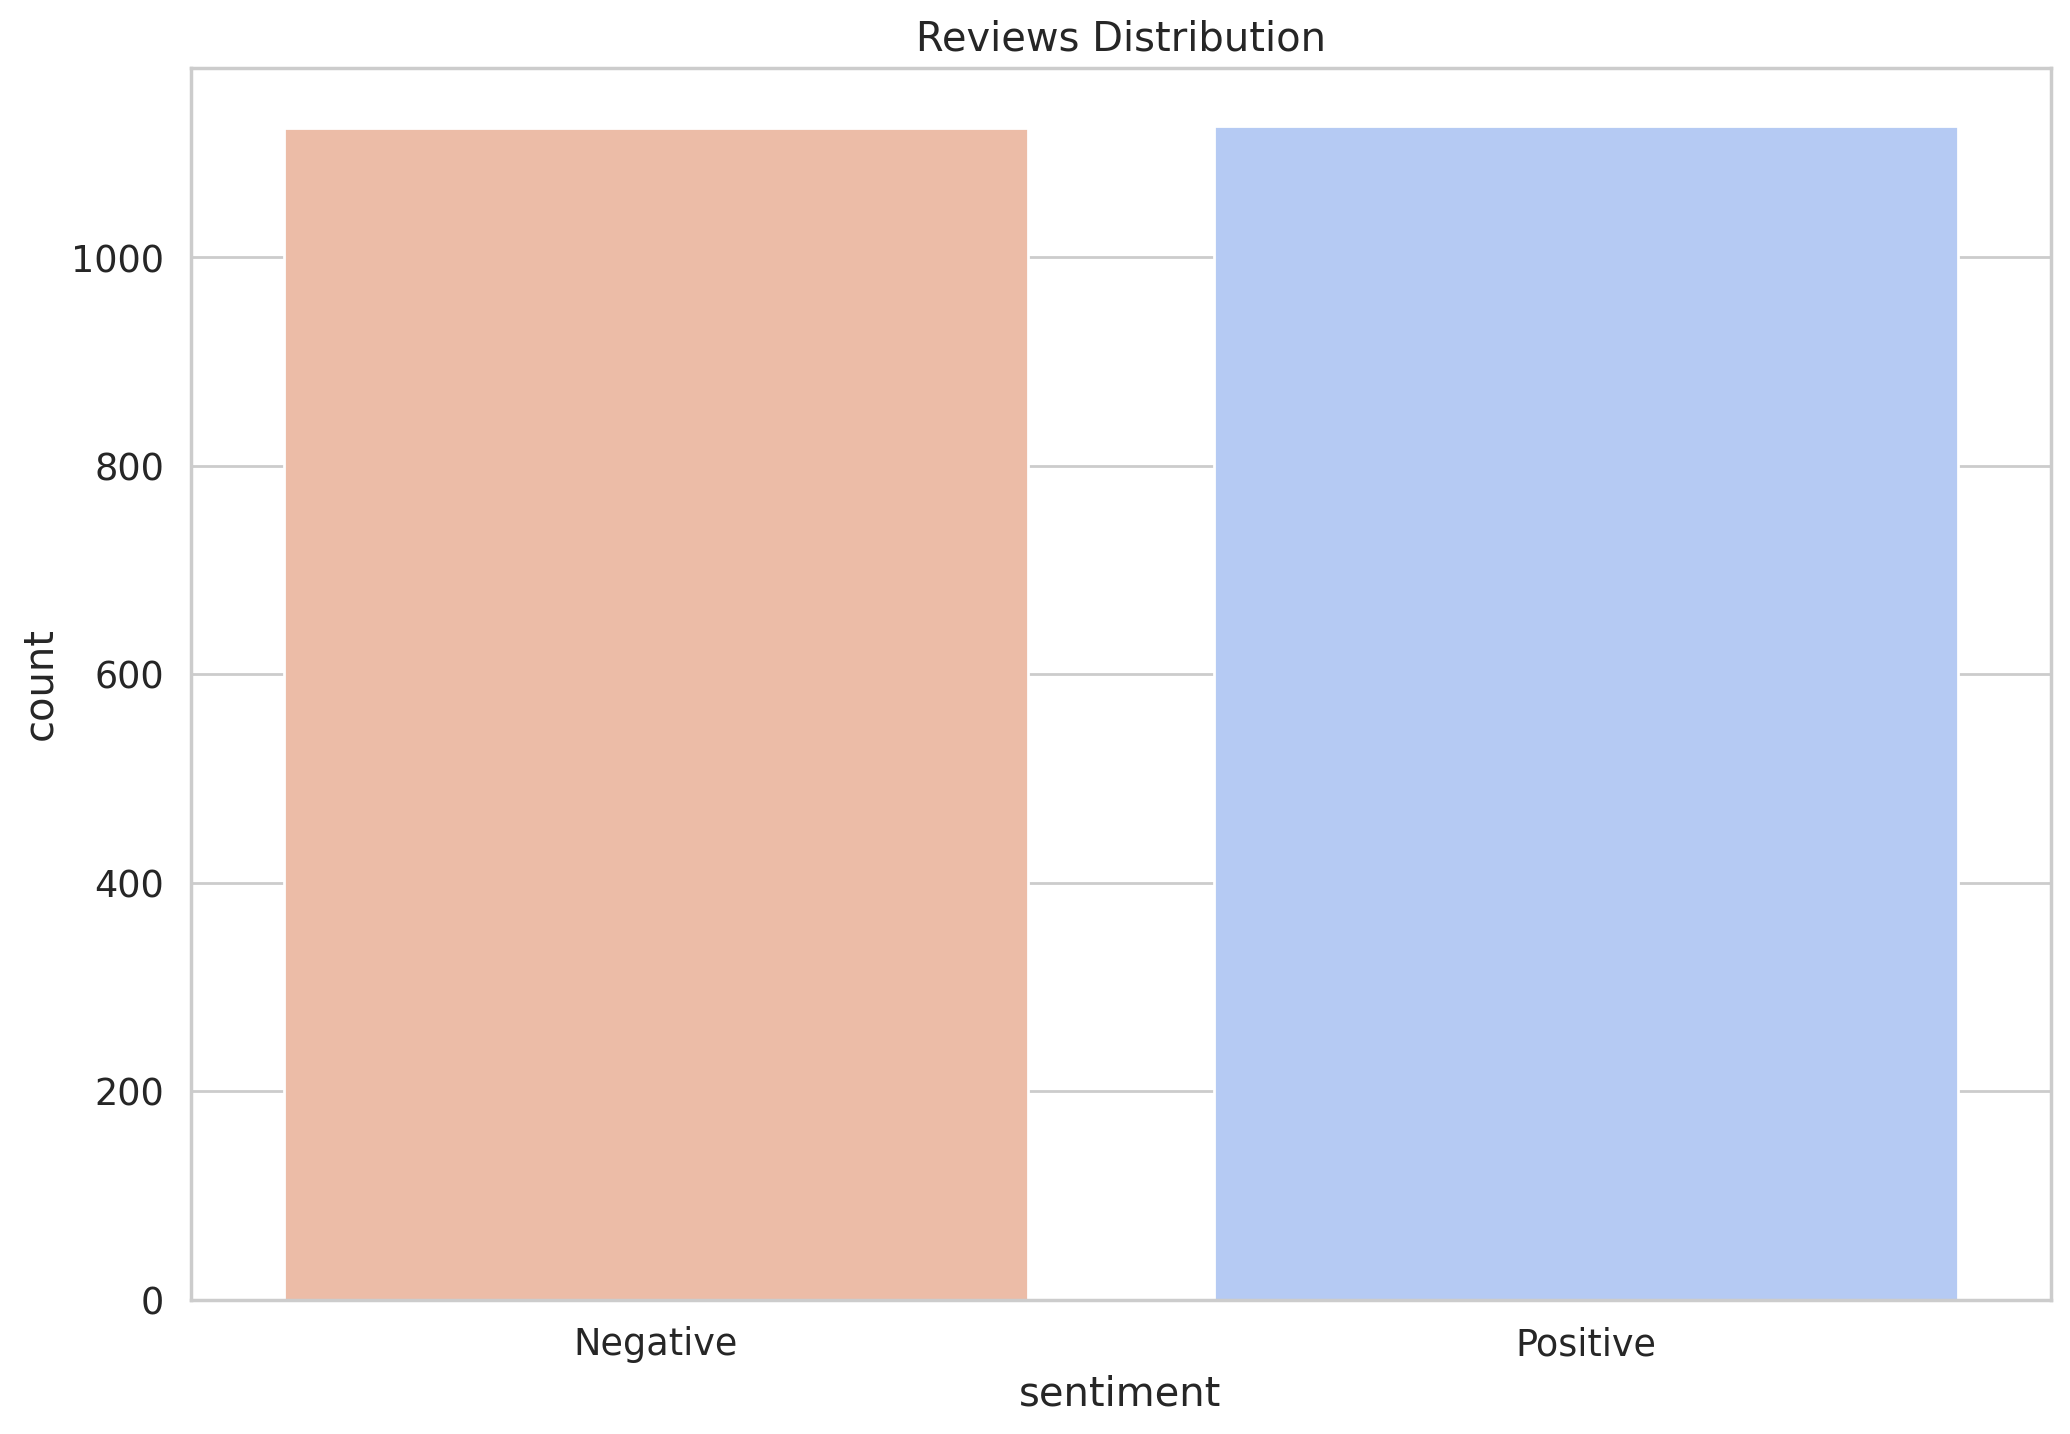

In [ ]:
ax = sns.countplot(x='sentiment',data=df,palette='coolwarm_r')
ax.set_xticklabels(['Negative','Positive']),
ax.set_title('Reviews Distribution')

In [ ]:

from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")


# Set the model name
MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'

# Build a BERT based tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

all_reviews = []

for rev in df.content:
  all_reviews.append(rev)
# Store length of each review
token_lens = []

pred = []
# Iterate through the content slide
for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=160,truncation=True)
    current_prediction = sentiment_pipeline(str(tokens))
    if current_prediction[0]['label'] == 'POSITIVE':
      pred.append(1)
    else:
      pred.append(0)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


0.38222222222222224


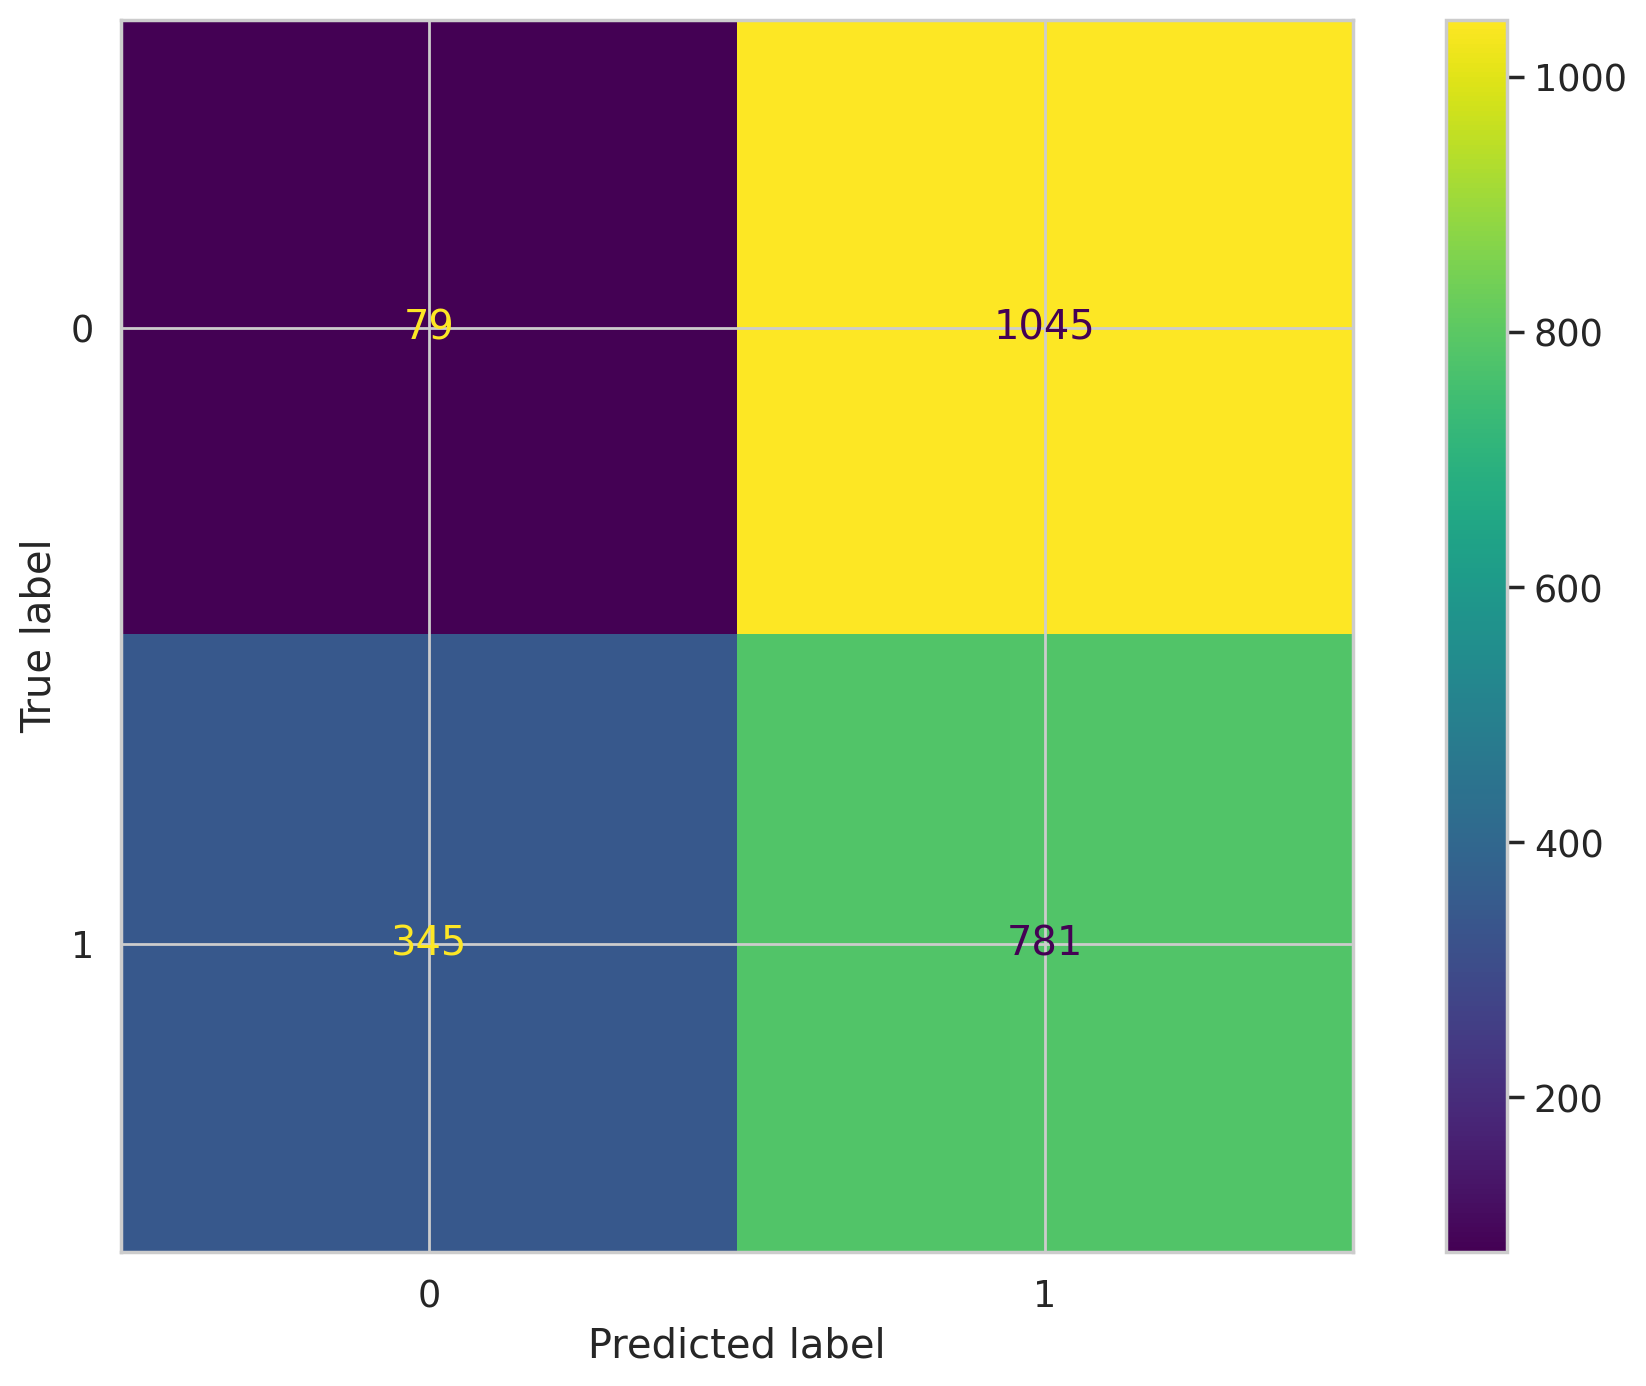

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

#Accuracy
print(accuracy_score(df.sentiment,pred))

#Confusion Matrix
ConfusionMatrixDisplay.from_predictions(df.sentiment,pred)

In [ ]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Store length of each review
token_lens = []

# Iterate through the content slide
for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

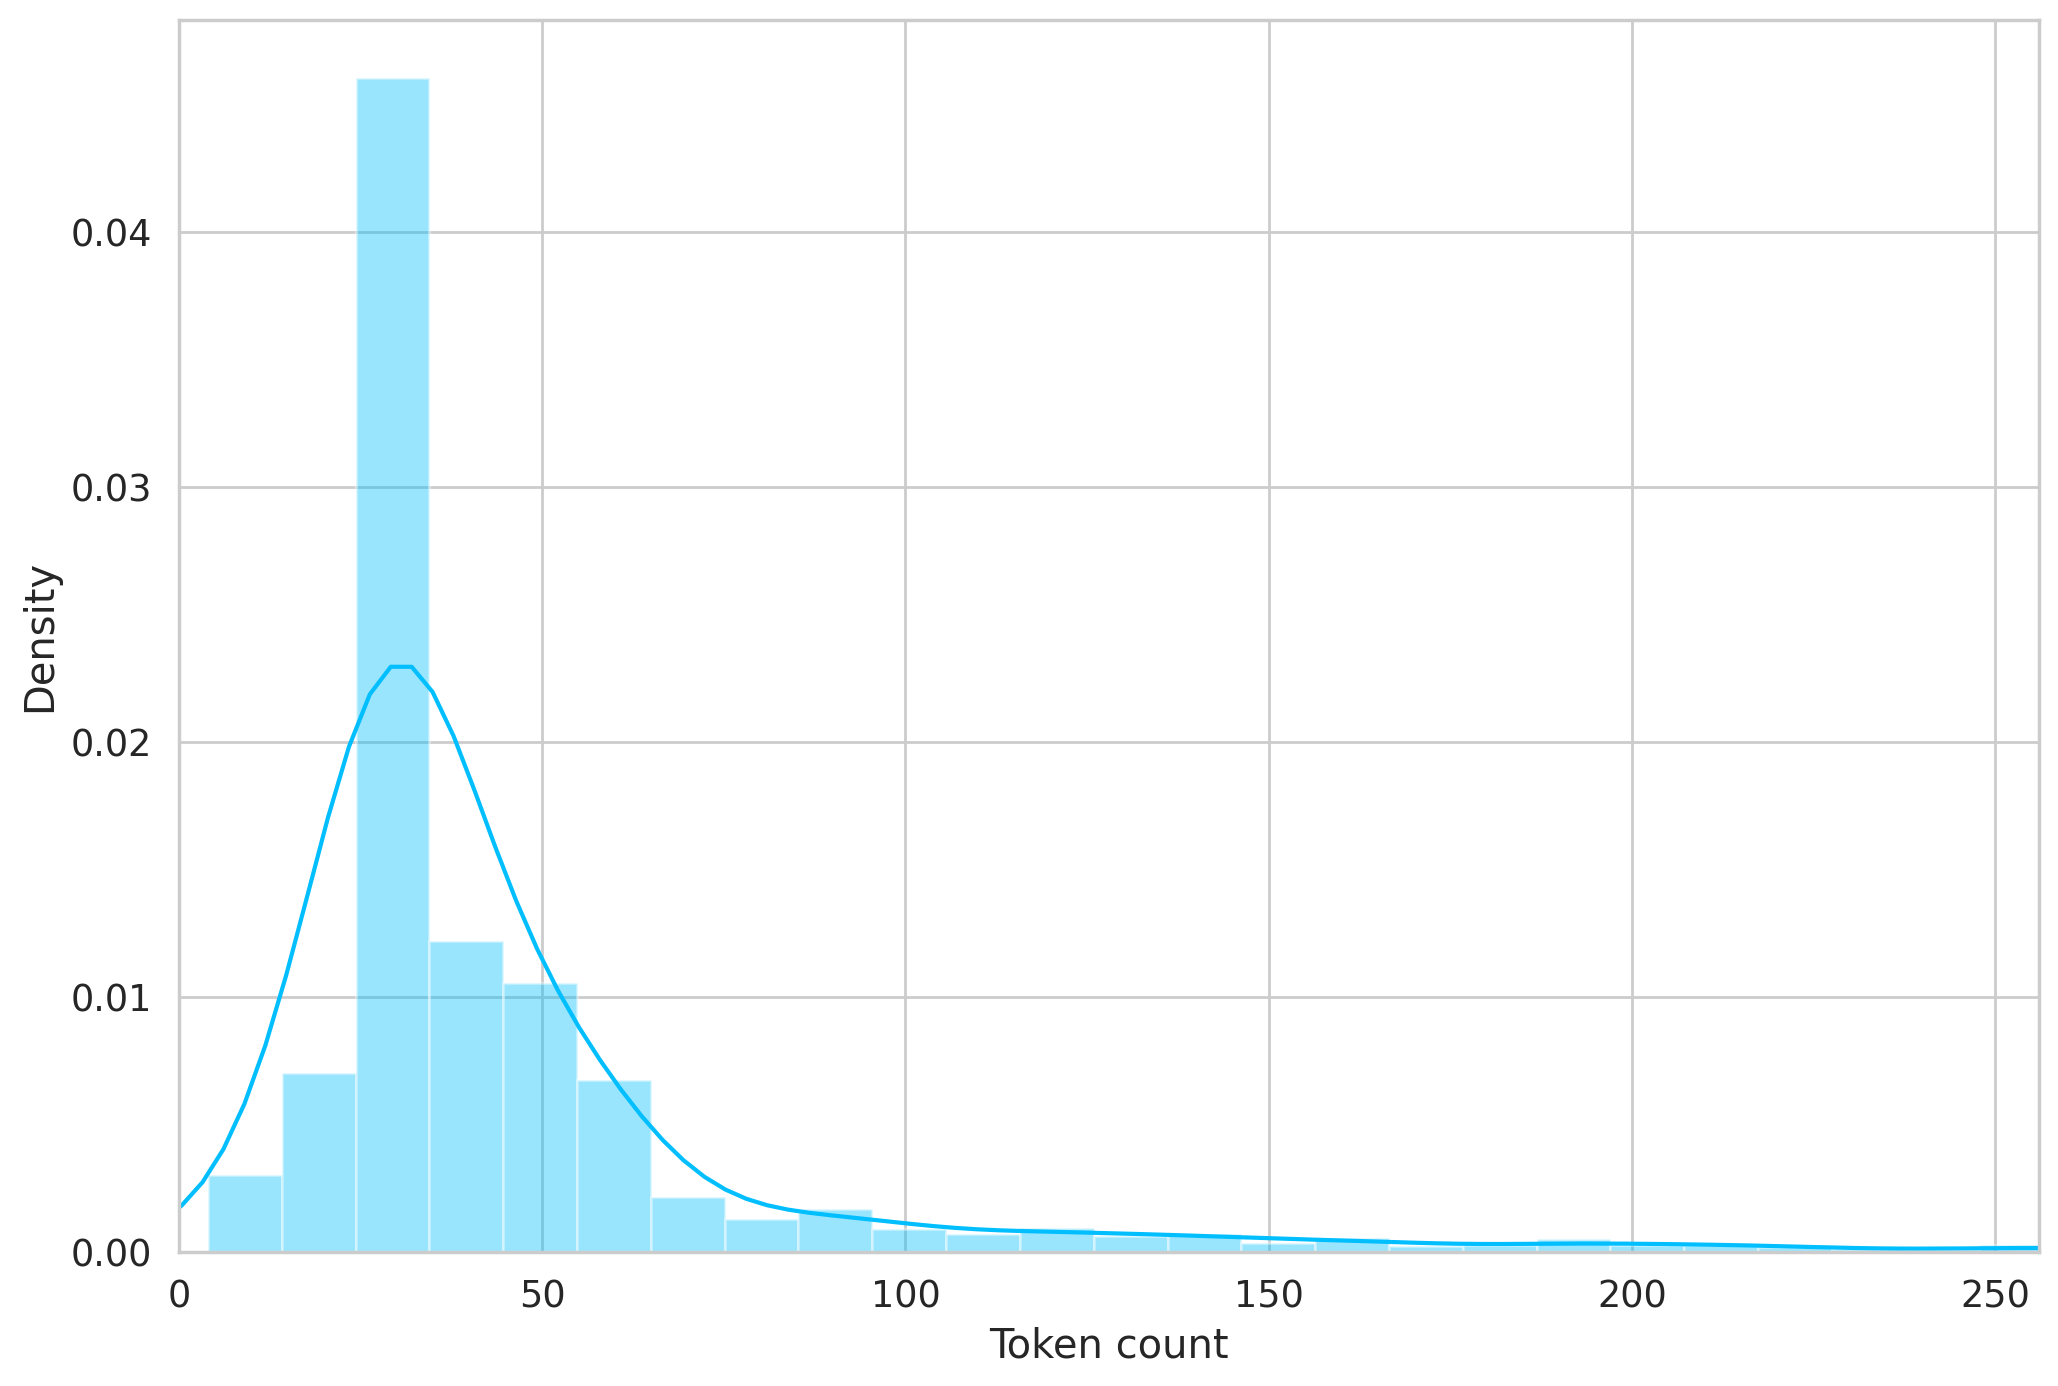

In [ ]:
# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 100

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED,stratify=df.sentiment)

print(df_train.shape, df_test.shape)

print(df_train.sentiment.value_counts())
print(df_test.sentiment.value_counts())


(1800, 2) (450, 2)
1    901
0    899
Name: sentiment, dtype: int64
1    225
0    225
Name: sentiment, dtype: int64


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

print(df_train.shape, df_test.shape)

(1800, 2) (450, 2)


In [ ]:
# Load the basic BERT model
bert_model = BertModel.from_pretrained(MODEL_NAME,return_dict=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME,return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask,return_dict):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
# Instantiate the model and move to classifier
model = SentimentClassifier(2)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


In [ ]:
# Number of iterations
EPOCHS = 10

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)#May need to change to binary

In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        return_dict=True)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    p = []
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            return_dict=True)

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            p.append(preds)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
        print(p)
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    test_acc, test_loss = eval_model(
        model,
        test_data_loader,
        loss_fn,
        device,
        len(df_test)
    )

    print(f"Test   loss {test_loss} accuracy {test_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(test_acc)
    history['val_loss'].append(test_loss)

    # If we beat prev performance
    if test_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = test_acc

Epoch 1/10
----------
Train loss 0.17071596413451057 accuracy 0.945
[tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0'), tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0'), tensor([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0'), tensor([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0'), tensor([1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0], device='cuda:0'), tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0'), tensor([1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1], device='cuda:0'), tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0'), tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0'), tensor([0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0'), tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0'), tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0'), tensor([1, 1, 0, 1, 0, 0, 0, 1,

TypeError: ignored

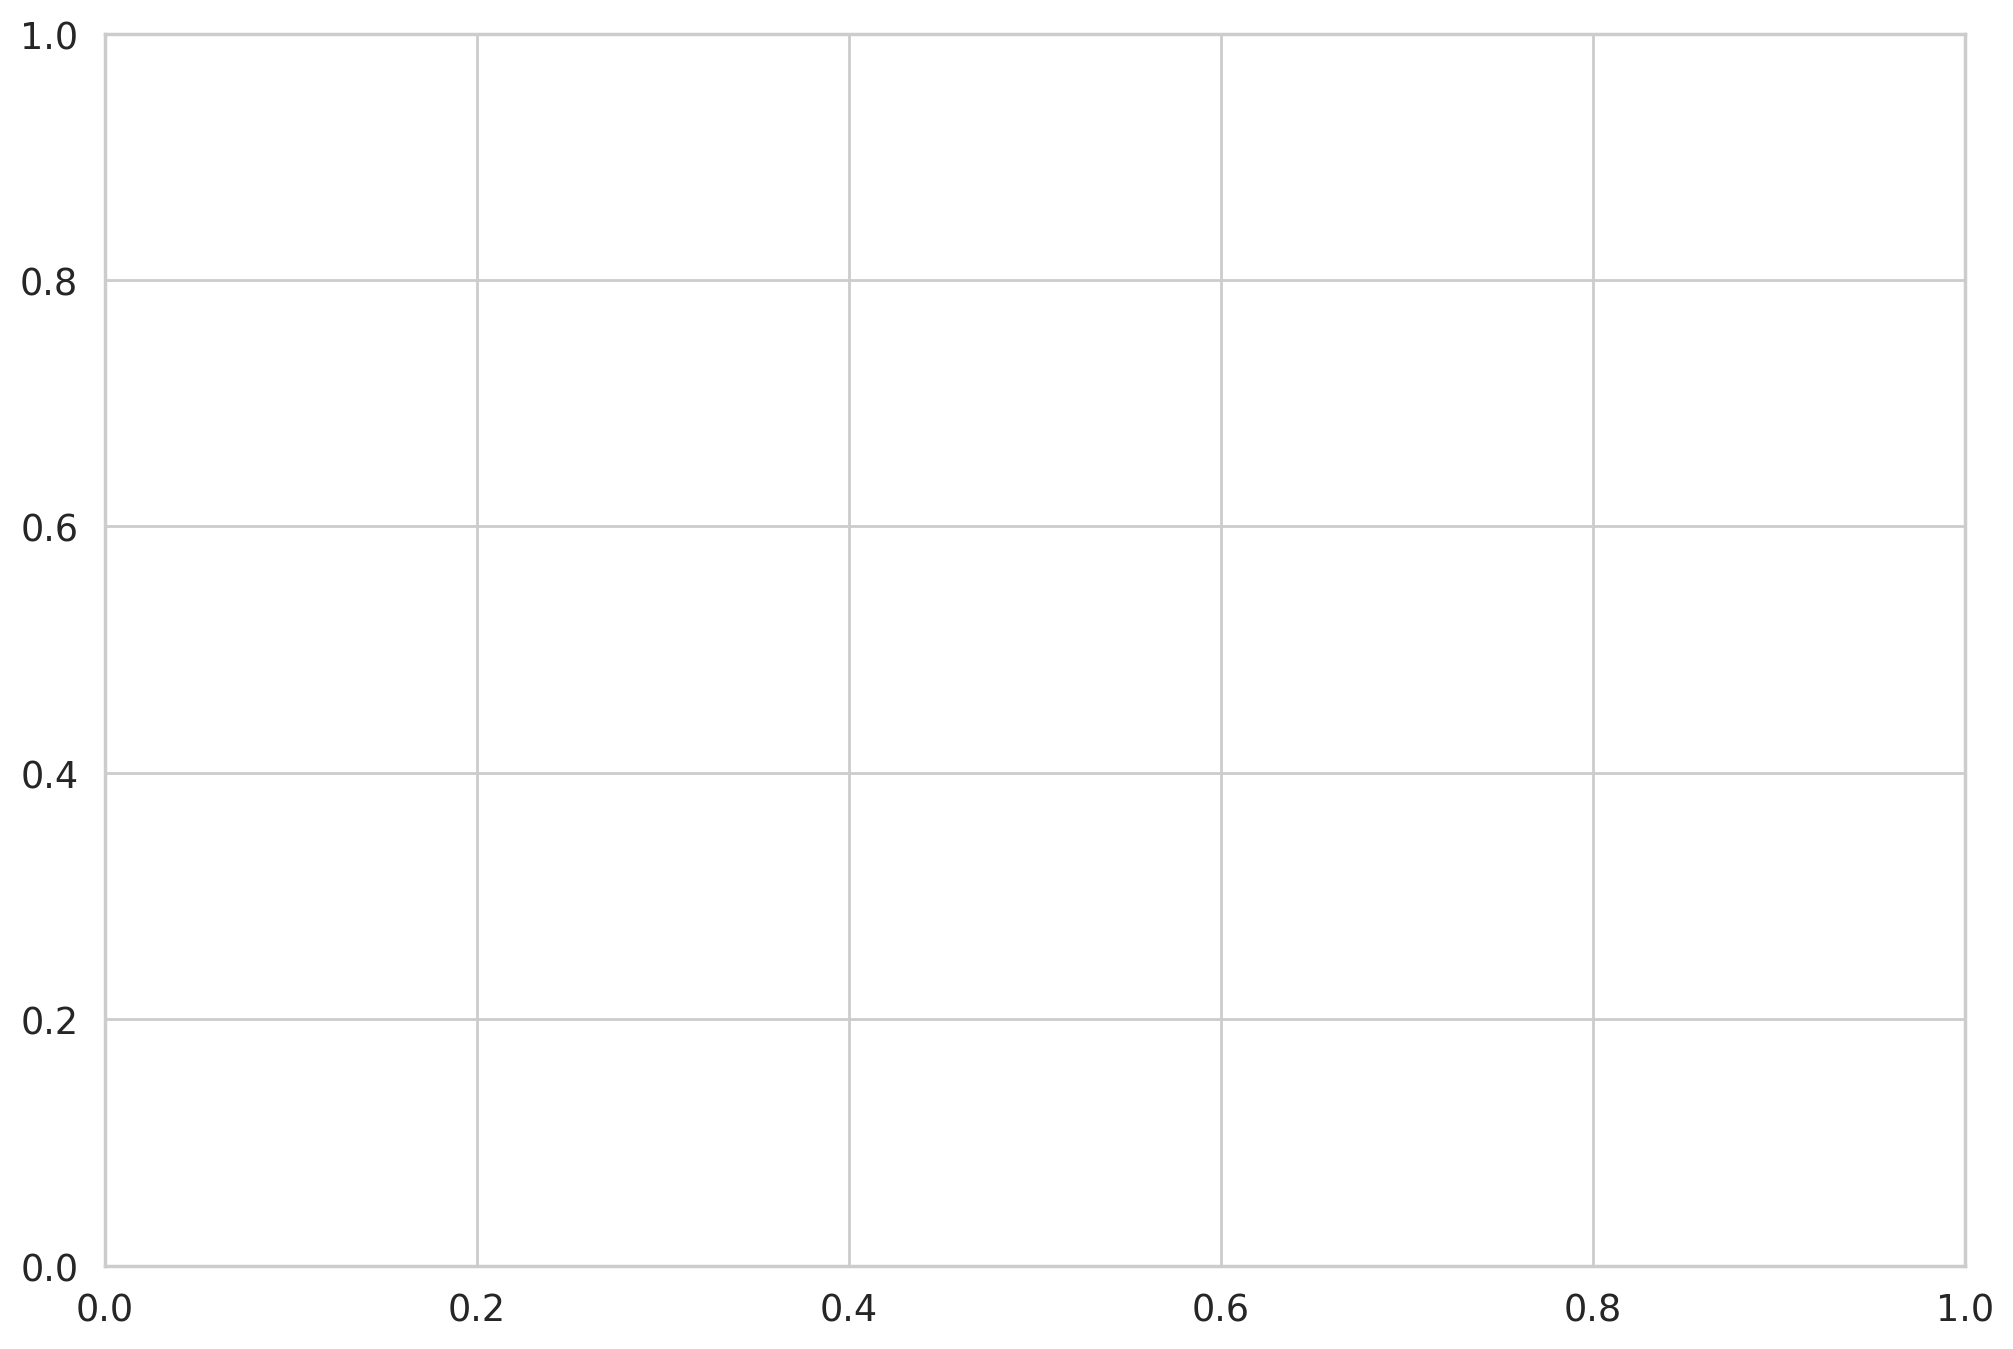

In [ ]:
# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
y_pred = model.predict(X_test).argmax(axis=-1)
#print(classification_report(data.test_y, y_pred))

AttributeError: ignored

In [ ]:
from transformers import pipeline
clf = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
answer = clf("text")

AttributeError: ignored